<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/learn_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# World's simplest convolvutional neural network
By [Fayyaz Minhas](https://sites.google.com/view/fayyaz/)

Welcome to "The World's Simplest Convolutional Neural Network" tutorial. In this journey, we will embark on a fascinating exploration of convolutional neural networks (CNNs), a cornerstone of modern machine learning techniques that have revolutionized computer vision and image processing.

Our adventure will be divided into three engaging sections:

1. The Concept of Filtering and Convolution: We'll start with the basics, uncovering the fundamental principles behind filtering and convolution. These operations are pivotal in understanding how computers can manipulate and interpret images. To make these concepts tangible, we will utilize the convolve function in scipy to apply filtering to an image. This hands-on approach will not only solidify your understanding but also demonstrate the practical applications of these concepts.

2. Implementing Convolution in PyTorch: After grasping the foundational knowledge, we will transition into the world of deep learning with PyTorch, a powerful and flexible machine learning library. You'll learn how to implement convolution on the same image using PyTorch, comparing and contrasting the process with our previous scipy implementation. This step will bridge the gap between traditional image processing techniques and modern deep learning approaches.

3. Making Learnable Convolution Filters in PyTorch: The climax of our tutorial will be the creation of a learnable convolution filter designed to detect + signs amidst - signs within an image. This segment will showcase the true power of CNNs — their ability to learn from data. By training our network to highlight + signs, you'll gain hands-on experience with training a simple neural network, and witness the network's ability to learn and adapt to perform a specific task.

By the end of this tutorial, you will have not only implemented your very own simple convolutional neural network but also acquired a foundational understanding of one of the most exciting and rapidly evolving fields in computer science.

## Important conceptual note

As we progress through this tutorial, an underlying theme we will explore is how convolutional neural networks can be viewed through the lens of "learning to filter." This concept is crucial for appreciating the essence of CNNs. Unlike traditional filters that are manually designed to perform specific tasks (e.g., edge detection, blurring), CNNs have the remarkable ability to learn optimal filters for a given task directly from the data using target information as a supervisory signal to guide the filters. This learning process enables CNNs to automatically identify and focus on the most relevant features of the input data, making them incredibly powerful for tasks such as image recognition, classification, and even generating new images.

By framing CNNs as a process of "learning to filter," we aim to demystify the magic behind these networks and encourage you to think about them not just as complex mathematical models, but as adaptive systems that evolve and improve through learning. This perspective will not only enhance your understanding of how CNNs work but also inspire you to envision the myriad possibilities they open up in the field of machine learning and beyond.


Let's get started:

## Convolution and Filtering

In this first part of our tutorial, we delve into the foundational concepts of filtering and convolution, key operations that enable computers to process and understand images. Our journey begins with a practical example using Python, leveraging the power of the scipy library to apply a filter to an image. Let's start by examining the equation of convolution, which is at the heart of this operation:
$$H(i,j)=(K∗I)(i,j)=\sum_{m}^{}\sum_{n}^{}K(m,n)⋅I(i−m,j−n)$$

Here, $H(i,j)$ represents the output image, $I$ is the input image, and $K$ is the kernel or filter applied to the image. The convolution operation involves flipping the kernel both horizontally and vertically and then sliding it over the image. At each position, it computes the sum of the element-wise product (or dot product) between the kernel and the portion of the image it covers.

To illustrate this, we use a specific filter K:

$$ K = \frac{1}{4} \begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix} $$

This filter is designed to detect edges in an image. But how does it achieve this? Edge detection hinges on identifying areas of high contrast, where pixel values change sharply. The filter K highlights such regions by emphasizing the difference between a pixel and its neighbors. When the filter encounters a uniform area, the sum approaches zero, rendering the area dark. Conversely, at the edges where pixel values change abruptly, the filter outputs higher values, making these regions brighter in the output image H.

Let's see this in action with the following code snippet:



sizes of images are: (512, 512) and (512, 512)


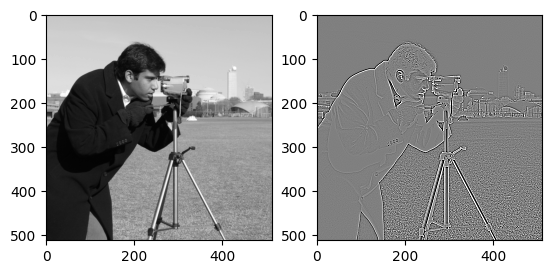

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import camera
from scipy.ndimage import convolve
K = np.array([[0,1,0],[1,-4,1],[0,1,0]])/4 # our filter. You can choose another one
I = camera()/255.0 #so that values are in the range 0-255
H = convolve(I,K)
plt.figure();plt.subplot(1,2,1); plt.imshow(I,cmap='gray')
plt.subplot(1,2,2); plt.imshow(H,vmin=-0.05,vmax=+0.05,cmap = 'gray')
print(f"sizes of images are: {I.shape} and {H.shape}")

This code loads an image, applies our edge-detecting filter, and displays both the original and processed images. Notice how the filtered image $H$ emphasizes the edges, making the structures within the image more pronounced.

Through this example, we witness the power of convolution and filtering in transforming images. By manipulating these operations, we can extract meaningful information from visual data, setting the stage for more complex image processing and machine learning applications.

As we proceed, keep in mind the significance of the filter and its impact on the output. Understanding this relationship is crucial as we venture into more advanced topics and eventually into the realm of convolutional neural networks, where filters become learnable parameters, adapting to perform specific tasks.

## Implementing filters in PyTorch

Transitioning from the scipy implementation of convolution, we now explore how to achieve the same operation within the PyTorch framework. PyTorch, a popular library for deep learning, offers a different perspective and a set of tools for image processing, particularly through its conv2d function for performing 2D convolutions. This section will guide you through implementing the convolution operation in PyTorch, and we'll discuss some nuances, such as input formatting and output size differences compared to scipy.

### Understanding PyTorch's Input Format
PyTorch's conv2d function expects input images in a specific format, known as NCHW format. This acronym stands for Number of images, Channels, Height, and Width. It's a departure from the typical height x width (HW) format of images. This requirement means that we must reshape our input images by adding two extra dimensions at the beginning: one for the batch size (N) and one for the number of channels (C). For grayscale images, C is 1, but for RGB images, C would be 3. This conversion is crucial for leveraging PyTorch's deep learning capabilities on image data.

### Implementing Convolution in PyTorch
To implement convolution in PyTorch, we define a custom Filter class extending nn.Module, PyTorch's base class for all neural network modules. Our class takes a kernel $K$ as input, converts it to a tensor, and adds the necessary dimensions to comply with the NCHW format. The forward method then performs the convolution using F.conv2d.

Here's the code snippet illustrating this process:


Convolution filter of dimensions: torch.Size([1, 1, 3, 3])
sizes of images are: (512, 512) and (510, 510)


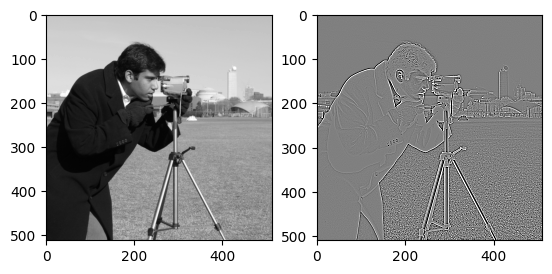

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class Filter(nn.Module):
    def __init__(self,K):
        super(Filter, self).__init__()
        K = torch.from_numpy(K).float()
        self.K = K.unsqueeze(0).unsqueeze(0) #convert image to NCHW from HW by adding two extra dimensions in the beginning
    def forward(self, x):
        return F.conv2d(x, self.K) #this is the convolution of the kernel
    def __repr__(self):
      return f"Convolution filter of dimensions: {self.K.shape}"

plt.close('all')
from skimage import data
X = data.camera()/255.0;
plt.subplot(1,2,1); plt.imshow(X,cmap='gray')
K = np.array([[0 ,1, 0],[1,-4,1], [0, 1 ,0]])/4.0
X_torch = torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0) #convert image to NCHW from HW by adding two extra dimensions in the beginning
#move image to torch
f = Filter(K)
#set the kernel in Filter object
Z_torch = f(X_torch)
#convolution
Z = Z_torch.squeeze().detach().numpy()
#move back to numpy
plt.subplot(1,2,2); plt.imshow(Z,vmin=-0.05,vmax=+0.05,cmap = 'gray')
print(f)
print(f"sizes of images are: {X.shape} and {Z.shape}")

### Differences in Output Image Size
You can observe a notable difference in the output and input image sizes when using PyTorch's conv2d function. By default, conv2d performs a valid convolution, meaning it does not add padding to the input image. As a result, the output image size is smaller than the input due to border overlap issues.  This contrasts with the scipy implementation, where the output size can match the input size if the convolution is performed with sufficient padding. Understanding this difference is crucial for designing neural networks and processing pipelines where the spatial dimensions of the output matter.

## Learning to Filter

In the previous sections, we explored how applying a predefined filter to an image can highlight certain features, such as edges. This process fundamentally changes the image by enhancing or suppressing specific patterns. A natural question that arises from this exploration is whether it's possible to create a filter that transforms a given input image into a desired output image. For instance, can we design a filter that highlights + signs in an input image, making them bright while leaving the rest of the image dark? Note that the process of filtering is inherently linear. Another interesting question is whether we can make nonlinear filters.

This part of our tutorial ventures into the realm of learnable filters using PyTorch, demonstrating how we can train a filter to achieve a specific image transformation. We will start by loading an image from the web and then proceed to learn a filter that highlights specified locations in the image, effectively answering our initial question.

### Loading the Image
First, we fetch an image hosted on GitHub using the requests library and display it using matplotlib. This image will serve as our input $X$.

Text(0.5, 1.0, 'Target Image')

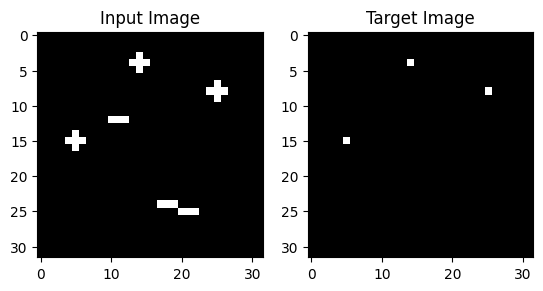

In [ ]:
def getImageAndTarget():
  #returns an image and a target matrix. You don't really need to understand this in too much detail.
  def draw_signs(image_size, plus_locations, minus_locations):
      # Create a zero matrix
      image = np.zeros(image_size)
      T = -np.ones_like(image)

      # Plus sign pattern (assuming a 3x3 pattern for simplicity)
      plus_pattern = np.array([[0, 1, 0],
                              [1, 1, 1],
                              [0, 1, 0]])

      # Minus sign pattern (assuming a 3x3 pattern for simplicity)
      minus_pattern = np.array([[0, 0, 0],
                                [1, 1, 1],
                                [0, 0, 0]])

      # Place plus signs
      for loc in plus_locations:
          x, y = loc
          image[x-1:x+2, y-1:y+2] = plus_pattern
          T[x,y] = 1

      # Place minus signs
      for loc in minus_locations:
          x, y = loc
          image[x-1:x+2, y-1:y+2] = minus_pattern

      return image,T

  # Example usage
  I_size = 32
  image_size = (I_size, I_size)  # Size of the matrix
  plus_locations = [(np.random.randint(3,I_size-3), np.random.randint(3,I_size-3)) for _ in range(3)]  # Locations for plus signs
  minus_locations = [(np.random.randint(3,I_size-3), np.random.randint(3,I_size-3)) for _ in range(3)]  # Locations for minus signs

  # Generate the matrix
  image,T = draw_signs(image_size, plus_locations, minus_locations)
  T-=np.mean(T) #ensure that mean of the labels is zero
  T/=np.max(T) #esnure that max value is 1.0
  return image,T

X,T = getImageAndTarget()
plt.subplot(1,2,1);plt.imshow(X,cmap='gray'); plt.title("Input Image")
plt.subplot(1,2,2);plt.imshow(T,cmap='gray'); plt.title('Target Image')


### Learning the Filter
To create a filter that can transform the input image $X$ into a target output $T$, we frame the problem as an optimization task. We seek a filter $K$ such that the convolution of $X$ with $K$ (denoted as $X∗K$) resembles $T$ as closely as possible.
#### Representation
Mathematically, we represent the convolution operation as:
$$H=f(X;K)=X∗K$$

We can also apply an activation function on the output to have the representation:

$$H=f(X;K)=\sigma(X∗K)$$

where, $\sigma(\cdot)$ is the activation functio such as tanh that will make a non-linear filter.  

See the note at the end of this tutorial on how practically we use correlation instead of convolution but that is a subtle detail in this context.

### Evaluation
Our goal becomes minimizing the difference between $H$ and $T$, expressed as the sum (or mean) absolute (or squared) error loss over pixels:

$$min_K loss(f(X;K),T) = \sum_{x,y} |H[x,y]-T[x,y]|$$.

### Optimization
We employ gradient descent to iteratively adjust $K$ to minimize this loss.

### Coding

The coding process involves defining a custom Filter class in PyTorch, which contains a convolutional layer initialized with a kernel size of our choosing. We then prepare the target $T$ by marking locations of interest with 1.0 and the rest with -1.0. Due to the convolution operation, the output size is smaller than the input size, so we adjust $T$ accordingly to match the output of our filter. We convert the input image and target to the appropriate format (NCHW), initialize our filter and optimizer, and commence training. During each iteration, we compute the loss as the mean squared error between the target and the output of our filter, apply a non-linear activation (tanh), and update the filter's weights using gradient descent. After training, we visualize the input, target, output, and the learned filter. The output image is rescaled to highlight the detected features. We also plot the loss over iterations to monitor the learning process.





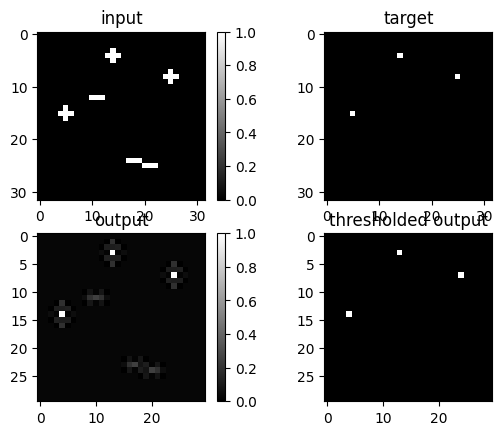

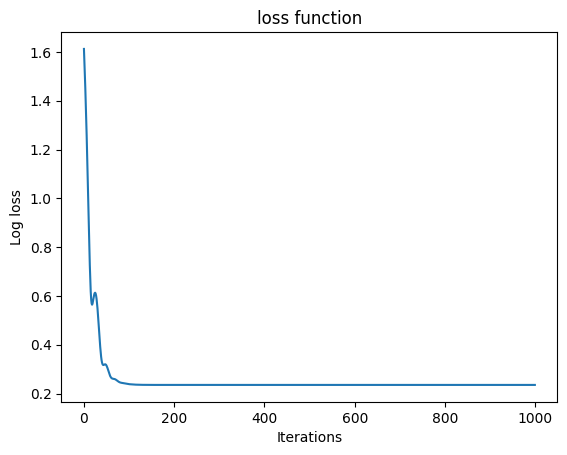

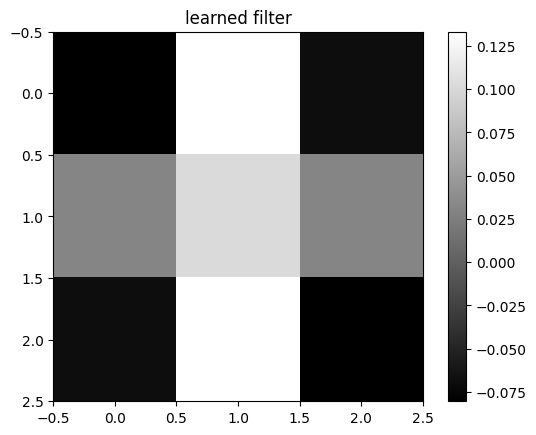

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
class Filter(nn.Module):
    def __init__(self, ksize = 3):
        super(Filter, self).__init__()
        self.conv1 = nn.Conv2d(1,1, ksize) #torch allows creating a convolution filter using a conv2d layer object which applies conv2d internally for a given input along with support for padding and different strides
    def forward(self, x):
        x = self.conv1(x) #perform convolution
        x = torch.tanh(x) #apply activation
        return x
# let's use a convolution filter of size ksize
ksize = 3
bsize = int(ksize/2) #size of broder region
f = Filter(ksize)
optimizer = torch.optim.Adam(f.parameters(), lr=1e-2)
T_torch = torch.from_numpy(T[bsize:-bsize,bsize:-bsize]).float()# reduce target filter size to compensate for border loss in convolution
X_torch = torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0) #convert image to NCHW from HW by adding two extra dimensions in the beginning
L = []
for _ in range(1000):
    optimizer.zero_grad() #optimization
    Z_torch = f(X_torch).squeeze()
    loss = torch.sum(torch.abs((T_torch-Z_torch)**2)) #error
    loss.backward()
    optimizer.step()
    L.append(loss.item())

output = Z_torch.squeeze().detach().numpy()
output = (output-np.min(output))/(np.max(output)-np.min(output)) #rescale so that the lowest value in the input image is 0 and the highest is 1 so we can threshold it
plt.figure();
plt.subplot(2,2,1);plt.imshow(X,cmap='gray');plt.title('input');plt.colorbar()
plt.subplot(2,2,2);plt.imshow(T,cmap='gray');plt.title('target')
plt.subplot(2,2,3);plt.imshow(output**2,cmap='gray');plt.title('output');plt.colorbar() # just squaring for some contrast enhancement to emphsize the high values
plt.subplot(2,2,4);plt.imshow(output>0.8,cmap='gray');plt.title('thresholded output')
plt.figure();plt.plot(np.log10(L));plt.xlabel('Iterations');plt.ylabel('Log loss');plt.title('loss function')
plt.figure();plt.imshow(f.conv1.weight.squeeze().detach().numpy(),cmap='gray');plt.title('learned filter');plt.colorbar()

## What if I told you that CNNs actually don't (need to) use convolution but instead use correlation?

In the realm of deep learning, particularly when discussing Convolutional Neural Networks (CNNs), there's a fascinating nuance that often goes unnoticed: despite their name, CNNs primarily use an operation that is more akin to cross-correlation rather than the mathematical convolution. This revelation might come as a surprise, especially given the extensive reference to "convolution" in the context of CNNs. Let's delve into this intriguing aspect, relating it back to the equation of convolution discussed earlier and exploring how cross-correlation is effectively utilized to detect patterns in images.

### Revisiting Convolution
Recall the equation for convolution discussed earlier, which in a discrete two-dimensional space for images can be represented as:
$$H(i,j)=(K∗I)(i,j)=\sum_{m}^{}\sum_{n}^{}K(m,n)⋅I(i−m,j−n)$$
This equation signifies a process where the image is flipped both horizontally and vertically before the kernel is applied to the image. The flipping is a critical step that distinguishes convolution from correlation. However, this mathematical purity of convolution, with its inherent flipping, is not what happens in the implementation of CNNs in libraries like PyTorch.

### The Role of Cross-Correlation
Instead of flipping the kernel, CNNs slide the unflipped kernel over the image, performing a dot product between the kernel values and the image pixels it covers at each position. This operation aligns with the process of cross-correlation, not convolution. In the context of PyTorch and similar deep learning libraries, the Conv2d layer effectively implements cross-correlation, which can be described as:

$$H(i,j)=(K\star I)(i,j)=\sum_{m}^{}\sum_{n}^{}K(m,n)⋅I(i+m,j+n)$$

Notice the absence of flipping in this operation, which is a key distinction from the convolution operation.

### Why Cross-Correlation Suffices
The use of cross-correlation over convolution in CNNs is not merely a technical curiosity but has practical implications. The goal of a CNN is to learn filters (kernels) that can detect specific features or patterns in the input images, such as edges, textures, or more complex shapes. Whether the kernel is flipped (as in convolution) or not (as in cross-correlation) does not change the network's ability to learn these patterns. During training, the CNN adjusts the values of the kernel to optimize the detection of these features, regardless of the kernel's orientation.

### Pattern Detection with Cross-Correlation
Viewing cross-correlation in the context of pattern detection offers a clear understanding of its effectiveness. When a CNN uses cross-correlation, it is essentially sliding a pattern (the kernel) across the image, looking for areas where the pattern matches closely with the image content. Areas of high similarity result in higher values in the output feature map, signaling the presence of the sought-after pattern. This process is analogous to looking for a specific shape in a puzzle; you move the shape around until you find a matching spot.

In our image detection task, the ideal correlation filter would be a "+" or a pattern which corresponds to an organization of pixels that are present in a "+" but not the background.

### Conclusion
Understanding that CNNs utilize cross-correlation instead of convolution sheds light on the adaptability and robustness of neural networks in feature detection tasks. This distinction underscores a broader principle in machine learning and deep learning: the importance lies not in strictly adhering to mathematical conventions but in leveraging computational techniques that achieve the desired outcome. As we peel back the layers of complexity in CNNs, we reveal the elegance of their operation—a testament to the power of pattern recognition and learning from data. Thus, while the name "Convolutional Neural Network" suggests a reliance on convolution, the essence of these networks lies in their ability to correlate patterns, a principle that has propelled CNNs to the forefront of advancements in image analysis and beyond.


## Next steps

This is a very simple fully convolutional neural network that learns a single convolution filter from a single example consisting of an input and target image pair. In practice, we use multiple filters such that the output of one goes into another one and we can reduce the dimensionality of the output through pooling as well.